In [11]:
# Import essential libraries
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import mediapipe as mp
from scipy.spatial import distance

# Import TensorFlow and Keras components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D,
    LSTM, GRU, Bidirectional, TimeDistributed, Concatenate, 
    GlobalAveragePooling2D, BatchNormalization, Reshape
)
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Import scikit-learn utilities
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Initialize MediaPipe hands module
mp_hands = mp.solutions.hands
mp_drawing = mp.solutions.drawing_utils

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set path to dataset
DATASET_PATH = 'bsl_dataset'

# Define parameters
NUM_FRAMES = 20  # Number of frames to sample per video
BATCH_SIZE = 32
EPOCHS = 30
IMG_SIZE = 224  # Input image size for the model

# Check dataset path exists
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset directory '{DATASET_PATH}' not found.")
else:
    print(f"Dataset found at {DATASET_PATH}")
    # Print dataset structure
    splits = [d for d in os.listdir(DATASET_PATH) if os.path.isdir(os.path.join(DATASET_PATH, d))]
    print(f"Dataset splits: {splits}")

Dataset found at bsl_dataset
Dataset splits: ['test', 'train', 'validation']


Testing MediaPipe processing on sample video: bsl_dataset/train/numbers/right_handed/one_handed/2/001.mp4


I0000 00:00:1740778418.925596   32608 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740778418.926924   38335 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics 620 (KBL GT2)


Video processed successfully.
Frames shape: (20, 224, 224, 3)
Landmarks shape: (20, 126)
Features shape: (20, 40)


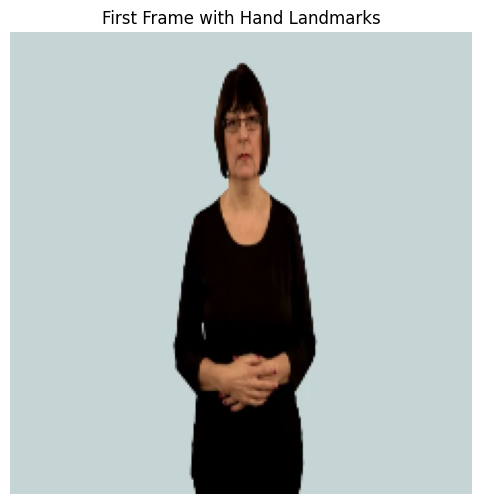

In [12]:
# Define functions for hand landmark extraction and processing with MediaPipe

def extract_hand_landmarks(frame, hands_detector):
    """Extract hand landmarks from a frame using MediaPipe"""
    # Convert the BGR image to RGB and process it with MediaPipe
    rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands_detector.process(rgb_frame)
    
    # Initialize output tensor for two hands (2 hands x 21 landmarks x 3 coordinates)
    landmarks_tensor = np.zeros((2, 21, 3), dtype=np.float32)
    
    # If hands are detected, extract landmarks
    if results.multi_hand_landmarks:
        # Process up to 2 hands
        for hand_idx, hand_landmarks in enumerate(results.multi_hand_landmarks[:2]):
            # Extract all 21 landmarks for the current hand
            for landmark_idx, landmark in enumerate(hand_landmarks.landmark):
                landmarks_tensor[hand_idx, landmark_idx, 0] = landmark.x
                landmarks_tensor[hand_idx, landmark_idx, 1] = landmark.y
                landmarks_tensor[hand_idx, landmark_idx, 2] = landmark.z
    
    # Flatten the tensor for model input (2 hands * 21 landmarks * 3 coordinates)
    return landmarks_tensor.reshape(-1)

def calculate_hand_features(landmarks):
    """Calculate additional hand features from landmarks"""
    # Reshape landmarks into the original structure (2 hands, 21 landmarks, 3 coordinates)
    landmarks = landmarks.reshape(2, 21, 3)
    
    features = []
    
    for hand_idx in range(2):  # Process each hand
        hand_landmarks = landmarks[hand_idx]
        
        if np.all(hand_landmarks == 0):  # Skip if hand is just zeros (not detected)
            features.extend(np.zeros(20))  # Add zeros for missing hand features
            continue
            
        # Calculate distances between fingertips and wrist
        wrist = hand_landmarks[0]
        thumb_tip = hand_landmarks[4]
        index_tip = hand_landmarks[8]
        middle_tip = hand_landmarks[12]
        ring_tip = hand_landmarks[16]
        pinky_tip = hand_landmarks[20]
        
        # Distance from wrist to each fingertip
        dist_wrist_thumb = distance.euclidean(wrist, thumb_tip)
        dist_wrist_index = distance.euclidean(wrist, index_tip)
        dist_wrist_middle = distance.euclidean(wrist, middle_tip)
        dist_wrist_ring = distance.euclidean(wrist, ring_tip)
        dist_wrist_pinky = distance.euclidean(wrist, pinky_tip)
        
        # Angles between fingers (using vectors)
        # Thumb to index
        v_thumb = thumb_tip - wrist
        v_index = index_tip - wrist
        angle_thumb_index = np.arccos(np.clip(np.dot(v_thumb, v_index) / 
                               (np.linalg.norm(v_thumb) * np.linalg.norm(v_index)), -1.0, 1.0))
        
        # Similarly for other finger pairs
        v_middle = middle_tip - wrist
        v_ring = ring_tip - wrist
        v_pinky = pinky_tip - wrist
        
        angle_index_middle = np.arccos(np.clip(np.dot(v_index, v_middle) / 
                                (np.linalg.norm(v_index) * np.linalg.norm(v_middle)), -1.0, 1.0))
        angle_middle_ring = np.arccos(np.clip(np.dot(v_middle, v_ring) / 
                               (np.linalg.norm(v_middle) * np.linalg.norm(v_ring)), -1.0, 1.0))
        angle_ring_pinky = np.arccos(np.clip(np.dot(v_ring, v_pinky) / 
                              (np.linalg.norm(v_ring) * np.linalg.norm(v_pinky)), -1.0, 1.0))
        
        # Features for this hand
        hand_features = [
            dist_wrist_thumb, dist_wrist_index, dist_wrist_middle, dist_wrist_ring, dist_wrist_pinky,
            angle_thumb_index, angle_index_middle, angle_middle_ring, angle_ring_pinky,
            # Add fingertip to fingertip distances
            distance.euclidean(thumb_tip, index_tip),
            distance.euclidean(index_tip, middle_tip),
            distance.euclidean(middle_tip, ring_tip),
            distance.euclidean(ring_tip, pinky_tip),
            distance.euclidean(thumb_tip, pinky_tip),
            # Add hand shape features (convex hull area, etc.)
            np.mean(hand_landmarks[:, 0]),  # Mean X position
            np.mean(hand_landmarks[:, 1]),  # Mean Y position
            np.mean(hand_landmarks[:, 2]),  # Mean Z position
            np.std(hand_landmarks[:, 0]),   # X spread
            np.std(hand_landmarks[:, 1]),   # Y spread
            np.std(hand_landmarks[:, 2]),   # Z spread
        ]
        
        features.extend(hand_features)
    
    return np.array(features)

def process_video_with_mediapipe(video_path, num_frames=20):
    """Process video to extract frames and hand landmarks"""
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"Error opening video file: {video_path}")
        return None, None, None
    
    # Get video properties
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Calculate frames to sample (evenly distributed)
    frames_to_sample = min(total_frames, num_frames)
    sample_indices = np.linspace(0, total_frames - 1, frames_to_sample, dtype=int)
    
    # Initialize MediaPipe hands detector
    with mp_hands.Hands(
        static_image_mode=False,
        max_num_hands=2,
        min_detection_confidence=0.5,
        min_tracking_confidence=0.5
    ) as hands:
        # Initialize arrays to store frames and landmarks
        frames = []
        all_landmarks = []
        all_features = []
        
        # Process video frame by frame
        frame_idx = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
                
            if frame_idx in sample_indices:
                # Resize frame for consistency
                frame = cv2.resize(frame, (224, 224))
                
                # Extract hand landmarks
                landmarks = extract_hand_landmarks(frame, hands)
                
                # Calculate additional hand features
                features = calculate_hand_features(landmarks)
                
                # Store results
                frames.append(frame)
                all_landmarks.append(landmarks)
                all_features.append(features)
                
            frame_idx += 1
            
        cap.release()
        
        # Convert to numpy arrays
        frames = np.array(frames)
        all_landmarks = np.array(all_landmarks)
        all_features = np.array(all_features)
        
        # Pad if necessary
        if len(frames) < num_frames:
            pad_frames = num_frames - len(frames)
            frames = np.pad(frames, ((0, pad_frames), (0, 0), (0, 0), (0, 0)), mode='constant')
            all_landmarks = np.pad(all_landmarks, ((0, pad_frames), (0, 0)), mode='constant')
            all_features = np.pad(all_features, ((0, pad_frames), (0, 0)), mode='constant')
            
        return frames, all_landmarks, all_features

# Test the functions on a sample video if available
if os.path.exists(DATASET_PATH):
    # Find a sample video for testing
    sample_video = None
    for root, dirs, files in os.walk(DATASET_PATH):
        for file in files:
            if file.endswith(('.mp4', '.avi')):
                sample_video = os.path.join(root, file)
                break
        if sample_video:
            break
    
    if sample_video:
        print(f"Testing MediaPipe processing on sample video: {sample_video}")
        frames, landmarks, features = process_video_with_mediapipe(sample_video, NUM_FRAMES)
        
        if frames is not None:
            print(f"Video processed successfully.")
            print(f"Frames shape: {frames.shape}")
            print(f"Landmarks shape: {landmarks.shape}")
            print(f"Features shape: {features.shape}")
            
            # Display the first frame with landmarks for visualization
            plt.figure(figsize=(10, 6))
            plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
            plt.title("First Frame with Hand Landmarks")
            plt.axis('off')
            plt.show()
    else:
        print("No sample videos found for testing.")

In [13]:
# Load and preprocess the BSL dataset

def load_dataset_with_mediapipe(base_dir, splits=["train", "validation", "test"], num_frames=20):
    """Load the BSL dataset with MediaPipe hand landmarks"""
    X_frames = {}
    X_landmarks = {}
    X_features = {}
    y_labels = {}
    
    all_classes = set()
    
    for split in splits:
        X_frames[split] = []
        X_landmarks[split] = []
        X_features[split] = []
        y_labels[split] = []
        
        split_dir = os.path.join(base_dir, split)
        if not os.path.exists(split_dir):
            print(f"Warning: Split directory {split_dir} not found")
            continue
        
        # Process categories (letters, numbers)
        for category in sorted(os.listdir(split_dir)):
            category_dir = os.path.join(split_dir, category)
            if not os.path.isdir(category_dir):
                continue
                
            # Process handedness (left_handed, right_handed)
            for handedness in sorted(os.listdir(category_dir)):
                handedness_dir = os.path.join(category_dir, handedness)
                if not os.path.isdir(handedness_dir):
                    continue
                
                # Process hand count (one_handed, two_handed)
                for hand_count in sorted(os.listdir(handedness_dir)):
                    hand_count_dir = os.path.join(handedness_dir, hand_count)
                    if not os.path.isdir(hand_count_dir):
                        continue
                    
                    # Process sign classes
                    for class_name in sorted(os.listdir(hand_count_dir)):
                        class_dir = os.path.join(hand_count_dir, class_name)
                        if not os.path.isdir(class_dir):
                            continue
                            
                        all_classes.add(class_name)
                        
                        # Process videos
                        for video_file in os.listdir(class_dir):
                            if video_file.endswith(('.mp4', '.avi')):
                                video_path = os.path.join(class_dir, video_file)
                                
                                # Extract frames and landmarks using MediaPipe
                                frames, landmarks, features = process_video_with_mediapipe(video_path, num_frames)
                                
                                if frames is not None:
                                    X_frames[split].append(frames)
                                    X_landmarks[split].append(landmarks)
                                    X_features[split].append(features)
                                    y_labels[split].append(class_name)
    
    # Convert to numpy arrays
    for split in splits:
        if X_frames[split]:  # Check if list is not empty
            X_frames[split] = np.array(X_frames[split])
            X_landmarks[split] = np.array(X_landmarks[split])
            X_features[split] = np.array(X_features[split])
            
    # Convert class names to integer labels
    label_encoder = LabelEncoder()
    label_encoder.fit(sorted(list(all_classes)))
    
    for split in splits:
        if y_labels[split]:  # Check if list is not empty
            y_labels[split] = to_categorical(label_encoder.transform(y_labels[split]))
    
    class_names = list(label_encoder.classes_)
    
    return {
        'X_frames': X_frames,
        'X_landmarks': X_landmarks,
        'X_features': X_features,
        'y_labels': y_labels,
        'class_names': class_names,
        'label_encoder': label_encoder
    }

def balance_dataset(dataset, max_samples_per_class=None):
    """Balance the dataset by ensuring each class has the same number of samples"""
    X_frames = dataset['X_frames']
    X_landmarks = dataset['X_landmarks']
    X_features = dataset['X_features']
    y_labels = dataset['y_labels']
    class_names = dataset['class_names']
    
    balanced_dataset = {
        'X_frames': {},
        'X_landmarks': {},
        'X_features': {},
        'y_labels': {},
        'class_names': class_names,
        'label_encoder': dataset['label_encoder']
    }
    
    for split in X_frames.keys():
        if len(X_frames[split]) == 0:
            balanced_dataset['X_frames'][split] = np.array([])
            balanced_dataset['X_landmarks'][split] = np.array([])
            balanced_dataset['X_features'][split] = np.array([])
            balanced_dataset['y_labels'][split] = np.array([])
            continue
            
        # Get class labels (convert from one-hot back to integers)
        y_labels_int = np.argmax(y_labels[split], axis=1)
        
        # Count samples per class
        unique_classes, class_counts = np.unique(y_labels_int, return_counts=True)
        
        # Determine target count (minimum count or specified max)
        if max_samples_per_class is None:
            target_count = np.min(class_counts)
        else:
            target_count = min(max_samples_per_class, np.max(class_counts))
        
        print(f"Balancing {split} set to {target_count} samples per class")
        
        # Initialize balanced arrays
        balanced_X_frames = []
        balanced_X_landmarks = []
        balanced_X_features = []
        balanced_y = []
        
        # Balance each class
        for class_idx in unique_classes:
            # Get indices for this class
            indices = np.where(y_labels_int == class_idx)[0]
            
            # If we need to upsample
            if len(indices) < target_count:
                # Sample with replacement
                sampled_indices = np.random.choice(indices, size=target_count, replace=True)
            else:
                # Sample without replacement
                sampled_indices = np.random.choice(indices, size=target_count, replace=False)
            
            # Add samples to balanced arrays
            balanced_X_frames.append(X_frames[split][sampled_indices])
            balanced_X_landmarks.append(X_landmarks[split][sampled_indices])
            balanced_X_features.append(X_features[split][sampled_indices])
            balanced_y.append(y_labels[split][sampled_indices])
        
        # Concatenate and shuffle
        balanced_X_frames = np.concatenate(balanced_X_frames, axis=0)
        balanced_X_landmarks = np.concatenate(balanced_X_landmarks, axis=0)
        balanced_X_features = np.concatenate(balanced_X_features, axis=0)
        balanced_y = np.concatenate(balanced_y, axis=0)
        
        # Shuffle
        shuffle_idx = np.random.permutation(len(balanced_y))
        balanced_dataset['X_frames'][split] = balanced_X_frames[shuffle_idx]
        balanced_dataset['X_landmarks'][split] = balanced_X_landmarks[shuffle_idx]
        balanced_dataset['X_features'][split] = balanced_X_features[shuffle_idx]
        balanced_dataset['y_labels'][split] = balanced_y[shuffle_idx]
    
    return balanced_dataset

# Load the dataset
print("Loading dataset with MediaPipe processing...")
datasets = load_dataset_with_mediapipe(DATASET_PATH, num_frames=NUM_FRAMES)

# Print dataset statistics
print("\nDataset statistics:")
for split in ["train", "validation", "test"]:
    if split in datasets['X_frames'] and len(datasets['X_frames'][split]) > 0:
        print(f"  {split.capitalize()} set: {len(datasets['X_frames'][split])} samples")
        
        # Count samples per class
        y_int = np.argmax(datasets['y_labels'][split], axis=1)
        unique_classes, counts = np.unique(y_int, return_counts=True)
        print(f"  Class distribution in {split} set:")
        for cls_idx, count in zip(unique_classes, counts):
            print(f"    {datasets['class_names'][cls_idx]}: {count} samples")

# Balance the dataset if needed
BALANCE_DATASET = False  # Set to True if you want to balance the dataset
if BALANCE_DATASET:
    print("\nBalancing dataset...")
    datasets = balance_dataset(datasets)
    print("Dataset balanced.")
    
    # Print balanced dataset statistics
    print("\nBalanced dataset statistics:")
    for split in ["train", "validation", "test"]:
        if split in datasets['X_frames'] and len(datasets['X_frames'][split]) > 0:
            print(f"  {split.capitalize()} set: {len(datasets['X_frames'][split])} samples")

print(f"\nTotal number of classes: {len(datasets['class_names'])}")
print(f"Class names: {datasets['class_names']}")

# Print input shapes for model creation
print("\nInput shapes:")
for split in ['train', 'validation', 'test']:
    if split in datasets['X_frames'] and len(datasets['X_frames'][split]) > 0:
        print(f"  {split} set:")
        print(f"    X_frames: {datasets['X_frames'][split].shape}")
        print(f"    X_landmarks: {datasets['X_landmarks'][split].shape}")
        print(f"    X_features: {datasets['X_features'][split].shape}")
        print(f"    y_labels: {datasets['y_labels'][split].shape}")
        break

Loading dataset with MediaPipe processing...


I0000 00:00:1740778419.975062   32608 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740778419.976199   38353 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics 620 (KBL GT2)
I0000 00:00:1740778420.875792   32608 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740778420.876787   38371 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics 620 (KBL GT2)
I0000 00:00:1740778421.498176   32608 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740778421.499221   38389 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), renderer: Mesa Intel(R) UHD Graphics 620 (KBL GT2)
I0000 00:00:1740778422.437144   32608 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1740778422.438193   38407 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 Mesa 22.3.6), ren


Dataset statistics:
  Train set: 61 samples
  Class distribution in train set:
    1: 8 samples
    10: 9 samples
    2: 6 samples
    3: 6 samples
    4: 6 samples
    5: 5 samples
    6: 6 samples
    7: 5 samples
    8: 5 samples
    9: 5 samples

Total number of classes: 20
Class names: [np.str_('1'), np.str_('10'), np.str_('11'), np.str_('12'), np.str_('13'), np.str_('14'), np.str_('15'), np.str_('16'), np.str_('17'), np.str_('18'), np.str_('19'), np.str_('2'), np.str_('20'), np.str_('3'), np.str_('4'), np.str_('5'), np.str_('6'), np.str_('7'), np.str_('8'), np.str_('9')]

Input shapes:
  train set:
    X_frames: (61, 20, 224, 224, 3)
    X_landmarks: (61, 20, 126)
    X_features: (61, 20, 40)
    y_labels: (61, 20)


In [14]:
# Create the multimodal model architecture

def create_multimodal_model(input_shapes, num_classes):
    """
    Create a multimodal model that processes video frames, landmarks, and calculated features
    
    Args:
        input_shapes: Dictionary containing shapes for frames, landmarks, and features
        num_classes: Number of output classes
    
    Returns:
        Compiled Keras model
    """
    # Unpack input shapes
    frame_input_shape = input_shapes['frames']
    landmark_input_shape = input_shapes['landmarks']
    feature_input_shape = input_shapes['features']
    
    print(f"Building model with input shapes:")
    print(f"  Frames: {frame_input_shape}")
    print(f"  Landmarks: {landmark_input_shape}")
    print(f"  Features: {feature_input_shape}")
    print(f"  Output classes: {num_classes}")
    
    # 1. Video frames processing branch
    frame_input = Input(shape=frame_input_shape, name='frame_input')
    
    # Use a pre-trained MobileNetV2 as feature extractor for each frame
    base_model = MobileNetV2(
        input_shape=(IMG_SIZE, IMG_SIZE, 3), 
        include_top=False, 
        weights='imagenet'
    )
    
    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Apply the base model to each frame using TimeDistributed
    x_frames = TimeDistributed(base_model)(frame_input)
    x_frames = TimeDistributed(GlobalAveragePooling2D())(x_frames)
    
    # Add bidirectional LSTM layers to process the sequence
    x_frames = Bidirectional(LSTM(128, return_sequences=True))(x_frames)
    x_frames = Bidirectional(LSTM(64))(x_frames)
    x_frames = Dropout(0.5)(x_frames)
    x_frames = Dense(128, activation='relu')(x_frames)
    
    # 2. Hand landmarks processing branch
    landmark_input = Input(shape=landmark_input_shape, name='landmark_input')
    
    # Process landmarks with LSTM
    x_landmarks = Reshape((NUM_FRAMES, -1))(landmark_input)  # Reshape for LSTM processing
    x_landmarks = Bidirectional(LSTM(64, return_sequences=True))(x_landmarks)
    x_landmarks = Bidirectional(LSTM(32))(x_landmarks)
    x_landmarks = Dropout(0.3)(x_landmarks)
    x_landmarks = Dense(64, activation='relu')(x_landmarks)
    
    # 3. Hand features processing branch
    feature_input = Input(shape=feature_input_shape, name='feature_input')
    
    # Process features with GRU
    x_features = Reshape((NUM_FRAMES, -1))(feature_input)  # Reshape for GRU processing
    x_features = GRU(32, return_sequences=True)(x_features)
    x_features = GRU(16)(x_features)
    x_features = Dropout(0.3)(x_features)
    x_features = Dense(32, activation='relu')(x_features)
    
    # Concatenate all branches
    combined = Concatenate()([x_frames, x_landmarks, x_features])
    
    # Final classification layers
    x = Dense(256, activation='relu')(combined)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    
    # Output layer
    output = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile model
    model = Model(
        inputs=[frame_input, landmark_input, feature_input],
        outputs=output
    )
    
    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Verify we have data to build the model
if 'train' in datasets['X_frames'] and len(datasets['X_frames']['train']) > 0:
    # Get input shapes for the model
    input_shapes = {
        'frames': datasets['X_frames']['train'].shape[1:],  # (num_frames, height, width, channels)
        'landmarks': datasets['X_landmarks']['train'].shape[1:],  # (num_frames * num_landmarks * 3)
        'features': datasets['X_features']['train'].shape[1:],  # (num_frames * num_features)
    }
    
    # Create the model
    num_classes = len(datasets['class_names'])
    model = create_multimodal_model(input_shapes, num_classes)
    
    # Print model summary
    print("\nModel Summary:")
    model.summary()
    
    # Plot model architecture
    try:
        tf.keras.utils.plot_model(
            model, 
            to_file='model_architecture.png',
            show_shapes=True, 
            show_dtype=False,
            show_layer_names=True,
            rankdir='TB', 
            expand_nested=True
        )
        print("\nModel architecture saved as 'model_architecture.png'")
    except Exception as e:
        print(f"Could not plot model architecture: {e}")
else:
    print("No training data available to build the model.")

Building model with input shapes:
  Frames: (20, 224, 224, 3)
  Landmarks: (20, 126)
  Features: (20, 40)
  Output classes: 20

Model Summary:


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ frame_input         │ (None, 20, 224,   │          0 │ -                 │
│ (InputLayer)        │ 224, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_2  │ (None, 20, 7, 7,  │  2,257,984 │ frame_input[0][0] │
│ (TimeDistributed)   │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ landmark_input      │ (None, 20, 126)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_input       │ (None, 20, 40)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_3  │ (None, 20, 1280)  │          0 │ time_distributed… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 20, 126)   │          0 │ landmark_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 20, 40)    │          0 │ feature_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 20, 256)   │  1,442,816 │ time_distributed… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_6     │ (None, 20, 128)   │     97,792 │ reshape_2[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_2 (GRU)         │ (None, 20, 32)    │      7,104 │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_5     │ (None, 128)       │    164,352 │ bidirectional_4[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_7     │ (None, 64)        │     41,216 │ bidirectional_6[… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_3 (GRU)         │ (None, 16)        │      2,400 │ gru_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ bidirectional_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 64)        │          0 │ bidirectional_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 16)        │          0 │ gru_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │     16,512 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 32)        │        544 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0],  

 Total params: 4,128,980 (15.75 MB)

 Trainable params: 1,870,484 (7.14 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.

Model architecture saved as 'model_architecture.png'


In [15]:
# Train and evaluate the multimodal model

def train_multimodal_model(model, datasets, epochs=EPOCHS, batch_size=BATCH_SIZE):
    """
    Train the multimodal model with the provided datasets
    
    Args:
        model: The compiled Keras model
        datasets: Dictionary containing training and validation data
        epochs: Maximum number of epochs
        batch_size: Batch size for training
        
    Returns:
        History object and trained model
    """
    # Extract training data
    X_frames_train = datasets['X_frames']['train']
    X_landmarks_train = datasets['X_landmarks']['train']
    X_features_train = datasets['X_features']['train']
    y_train = datasets['y_labels']['train']
    
    # Extract validation data
    X_frames_val = datasets['X_frames']['validation']
    X_landmarks_val = datasets['X_landmarks']['validation']
    X_features_val = datasets['X_features']['validation']
    y_val = datasets['y_labels']['validation']
    
    # Set up callbacks for training
    callbacks = [
        # Early stopping to prevent overfitting
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True,
            verbose=1
        ),
        
        # Reduce learning rate when training plateaus
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.2,
            patience=5,
            min_lr=1e-6,
            verbose=1
        ),
        
        # Save best model
        tf.keras.callbacks.ModelCheckpoint(
            filepath='best_bsl_model.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        ),
        
        # TensorBoard logging
        tf.keras.callbacks.TensorBoard(
            log_dir='./logs',
            histogram_freq=1
        )
    ]
    
    # Train the model
    print(f"\nTraining model for up to {epochs} epochs with batch size {batch_size}...")
    history = model.fit(
        x=[X_frames_train, X_landmarks_train, X_features_train],
        y=y_train,
        validation_data=([X_frames_val, X_landmarks_val, X_features_val], y_val),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model

def visualize_training_history(history):
    """
    Visualize the training history
    
    Args:
        history: History object returned by model.fit()
    """
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
    
    # Plot training & validation accuracy
    ax1.plot(history.history['accuracy'])
    ax1.plot(history.history['val_accuracy'])
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Validation'], loc='upper left')
    ax1.grid(True)
    
    # Plot training & validation loss
    ax2.plot(history.history['loss'])
    ax2.plot(history.history['val_loss'])
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(['Train', 'Validation'], loc='upper right')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Print final metrics
    print("\nFinal training metrics:")
    final_epoch = len(history.history['accuracy']) - 1
    print(f"  Training accuracy: {history.history['accuracy'][final_epoch]:.4f}")
    print(f"  Validation accuracy: {history.history['val_accuracy'][final_epoch]:.4f}")
    print(f"  Training loss: {history.history['loss'][final_epoch]:.4f}")
    print(f"  Validation loss: {history.history['val_loss'][final_epoch]:.4f}")
    
    # Print best epoch
    best_epoch = np.argmax(history.history['val_accuracy'])
    print(f"\nBest model at epoch {best_epoch + 1}:")
    print(f"  Validation accuracy: {history.history['val_accuracy'][best_epoch]:.4f}")
    print(f"  Validation loss: {history.history['val_loss'][best_epoch]:.4f}")

def evaluate_model(model, datasets):
    """
    Evaluate the trained model on the test set
    
    Args:
        model: Trained Keras model
        datasets: Dictionary containing test data
        
    Returns:
        Test accuracy and loss
    """
    # Check if test data exists
    if 'test' not in datasets['X_frames'] or len(datasets['X_frames']['test']) == 0:
        print("No test data available for evaluation.")
        return None, None
    
    # Extract test data
    X_frames_test = datasets['X_frames']['test']
    X_landmarks_test = datasets['X_landmarks']['test']
    X_features_test = datasets['X_features']['test']
    y_test = datasets['y_labels']['test']
    
    # Evaluate the model
    print("\nEvaluating model on test set...")
    test_loss, test_acc = model.evaluate(
        [X_frames_test, X_landmarks_test, X_features_test],
        y_test,
        verbose=1
    )
    
    print(f"Test accuracy: {test_acc:.4f}")
    print(f"Test loss: {test_loss:.4f}")
    
    # Generate predictions
    y_pred_probs = model.predict([X_frames_test, X_landmarks_test, X_features_test])
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)
    
    # Plot confusion matrix
    plt.figure(figsize=(15, 12))
    cm = confusion_matrix(y_true, y_pred)
    
    # Normalize confusion matrix
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Create heatmap
    sns.heatmap(
        cm_norm, 
        annot=True, 
        fmt='.2f', 
        cmap='Blues',
        xticklabels=datasets['class_names'],
        yticklabels=datasets['class_names']
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Normalized Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(
        y_true, 
        y_pred, 
        target_names=datasets['class_names']
    ))
    
    return test_loss, test_acc

# Train the model if available
if 'model' in locals() and 'train' in datasets['X_frames'] and 'validation' in datasets['X_frames']:
    # Check if we have enough samples
    min_samples = 10
    
    if len(datasets['X_frames']['train']) < min_samples:
        print(f"Not enough training samples. Found {len(datasets['X_frames']['train'])}, need at least {min_samples}.")
    elif len(datasets['X_frames']['validation']) < min_samples:
        print(f"Not enough validation samples. Found {len(datasets['X_frames']['validation'])}, need at least {min_samples}.")
    else:
        # Train the model
        history, model = train_multimodal_model(model, datasets)
        
        # Visualize training history
        visualize_training_history(history)
        
        # Save the model
        model.save('bsl_multimodal_model.h5')
        print("\nModel saved as 'bsl_multimodal_model.h5'")
        
        # Evaluate the model on test set if available
        if 'test' in datasets['X_frames'] and len(datasets['X_frames']['test']) >= min_samples:
            evaluate_model(model, datasets)
else:
    print("Model or datasets not available for training.")

Not enough validation samples. Found 0, need at least 10.


In [16]:
# Export model to TFLite and optimize

import time

def export_to_tflite(model, dataset, optimization_level="DEFAULT"):
    """
    Export the trained model to TFLite format with different optimization levels
    
    Args:
        model: Trained Keras model
        dataset: Dictionary containing test data for representative dataset
        optimization_level: Optimization level (DEFAULT, OPTIMIZE_FOR_SIZE, OPTIMIZE_FOR_LATENCY)
        
    Returns:
        TFLite model as bytes
    """
    print(f"Exporting model to TFLite with optimization level: {optimization_level}")
    
    # Create TFLite converter
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    
    # Set optimization flag
    if optimization_level == "OPTIMIZE_FOR_SIZE":
        converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
    elif optimization_level == "OPTIMIZE_FOR_LATENCY":
        converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_LATENCY]
    elif optimization_level == "DEFAULT":
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    
    # Fix for LSTM layers
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    converter.experimental_enable_resource_variables = True
    
    # Define representative dataset generator for quantization
    if 'validation' in dataset['X_frames'] and len(dataset['X_frames']['validation']) > 0:
        def representative_dataset():
            # Use a subset of validation data
            num_samples = min(100, len(dataset['X_frames']['validation']))
            for i in range(num_samples):
                frames = np.expand_dims(dataset['X_frames']['validation'][i], axis=0)
                landmarks = np.expand_dims(dataset['X_landmarks']['validation'][i], axis=0)
                features = np.expand_dims(dataset['X_features']['validation'][i], axis=0)
                yield [frames, landmarks, features]
        
        # Use float fallback for complex ops
        converter.representative_dataset = representative_dataset
        # Don't force uint8 for inputs/outputs as it may cause issues with complex model
        print("Using quantization with representative dataset")
    else:
        print("No validation data for representative dataset. Using default optimization.")
    
    try:
        # Convert the model
        print("Converting model to TFLite format...")
        tflite_model = converter.convert()
        
        # Save the model to file
        filename = f"bsl_model_{optimization_level.lower()}.tflite"
        with open(filename, 'wb') as f:
            f.write(tflite_model)
        print(f"Model saved as {filename}")
        
        # Calculate model size
        model_size_mb = len(tflite_model) / (1024 * 1024)
        print(f"TFLite model size: {model_size_mb:.2f} MB")
        
        return tflite_model
    except Exception as e:
        print(f"Error converting model to TFLite: {e}")
        # Try with a different approach - saving and loading as a workaround
        try:
            print("Trying alternative conversion approach...")
            # Save model temporarily
            temp_model_path = "temp_model.h5"
            model.save(temp_model_path)
            
            # Load model with TFLite compatible settings
            converter = tf.lite.TFLiteConverter.from_saved_model(temp_model_path)
            converter.target_spec.supported_ops = [
                tf.lite.OpsSet.TFLITE_BUILTINS,
                tf.lite.OpsSet.SELECT_TF_OPS
            ]
            
            # Convert the model
            tflite_model = converter.convert()
            
            # Save the model to file
            filename = f"bsl_model_{optimization_level.lower()}.tflite"
            with open(filename, 'wb') as f:
                f.write(tflite_model)
            print(f"Model saved as {filename} using alternative approach")
            
            # Remove temporary file
            if os.path.exists(temp_model_path):
                os.remove(temp_model_path)
                
            return tflite_model
        except Exception as e2:
            print(f"Alternative approach also failed: {e2}")
            # Final fallback - simplify the conversion without optimizations
            try:
                print("Trying minimal conversion approach...")
                converter = tf.lite.TFLiteConverter.from_keras_model(model)
                converter.target_spec.supported_ops = [
                    tf.lite.OpsSet.TFLITE_BUILTINS,
                    tf.lite.OpsSet.SELECT_TF_OPS
                ]
                tflite_model = converter.convert()
                
                # Save the model to file
                filename = f"bsl_model_{optimization_level.lower()}_minimal.tflite"
                with open(filename, 'wb') as f:
                    f.write(tflite_model)
                print(f"Model saved as {filename} using minimal approach")
                
                return tflite_model
            except Exception as e3:
                print(f"All conversion approaches failed. Last error: {e3}")
                return None

def compare_tflite_performance(model, tflite_models, dataset):
    """
    Compare performance between the original model and TFLite models
    
    Args:
        model: Original Keras model
        tflite_models: Dictionary of TFLite models with optimization levels as keys
        dataset: Dictionary containing test data
    """
    # Check if test data exists
    if 'test' not in dataset['X_frames'] or len(dataset['X_frames']['test']) == 0:
        print("No test data available for comparison.")
        return
    
    # Get a subset of test data for performance testing
    num_samples = min(100, len(dataset['X_frames']['test']))
    frames = dataset['X_frames']['test'][:num_samples]
    landmarks = dataset['X_landmarks']['test'][:num_samples]
    features = dataset['X_features']['test'][:num_samples]
    y_true = np.argmax(dataset['y_labels']['test'][:num_samples], axis=1)
    
    # Results dictionary
    results = {}
    
    # Measure original model performance
    print("\nMeasuring original model performance...")
    start_time = time.time()
    original_preds = model.predict([frames, landmarks, features])
    original_time = time.time() - start_time
    original_accuracy = np.mean(np.argmax(original_preds, axis=1) == y_true)
    
    results['original'] = {
        'time': original_time,
        'time_per_sample': original_time / num_samples,
        'accuracy': original_accuracy
    }
    
    # Measure TFLite models performance
    for opt_level, tflite_model in tflite_models.items():
        if tflite_model is None:
            print(f"Skipping {opt_level} TFLite model as conversion failed.")
            continue
            
        print(f"\nMeasuring {opt_level} TFLite model performance...")
        
        try:
            # Initialize the TFLite interpreter
            interpreter = tf.lite.Interpreter(model_content=tflite_model)
            interpreter.allocate_tensors()
            
            # Get input and output details
            input_details = interpreter.get_input_details()
            output_details = interpreter.get_output_details()
            
            # Run inference on all samples
            tflite_preds = []
            start_time = time.time()
            
            for i in range(num_samples):
                # Set input tensors
                interpreter.set_tensor(input_details[0]['index'], np.expand_dims(frames[i], axis=0).astype(np.float32))
                interpreter.set_tensor(input_details[1]['index'], np.expand_dims(landmarks[i], axis=0).astype(np.float32))
                interpreter.set_tensor(input_details[2]['index'], np.expand_dims(features[i], axis=0).astype(np.float32))
                
                # Run inference
                interpreter.invoke()
                
                # Get output tensors
                output_data = interpreter.get_tensor(output_details[0]['index'])
                tflite_preds.append(output_data[0])
            
            tflite_time = time.time() - start_time
            tflite_preds = np.array(tflite_preds)
            tflite_accuracy = np.mean(np.argmax(tflite_preds, axis=1) == y_true)
            
            results[opt_level] = {
                'time': tflite_time,
                'time_per_sample': tflite_time / num_samples,
                'accuracy': tflite_accuracy
            }
        except Exception as e:
            print(f"Error testing {opt_level} TFLite model: {e}")
    
    # Print results
    print("\nPerformance Comparison:")
    print(f"{'Model':20} {'Time (s)':15} {'Time/Sample (s)':15} {'Accuracy':10}")
    print("-" * 60)
    
    for model_name, metrics in results.items():
        print(f"{model_name:20} {metrics['time']:.4f}s{' '*8} {metrics['time_per_sample']:.4f}s{' '*8} {metrics['accuracy']:.4f}")
    
    # Plot comparison if we have at least one TFLite model successfully converted
    if len(results) > 1:
        plt.figure(figsize=(15, 6))
        
        # Plot 1: Inference Time
        plt.subplot(1, 2, 1)
        models = list(results.keys())
        times = [results[m]['time_per_sample'] * 1000 for m in models]  # Convert to ms
        plt.bar(models, times)
        plt.title('Average Inference Time per Sample')
        plt.ylabel('Time (ms)')
        plt.grid(axis='y', alpha=0.3)
        
        # Plot 2: Accuracy
        plt.subplot(1, 2, 2)
        accuracies = [results[m]['accuracy'] * 100 for m in models]  # Convert to percentage
        plt.bar(models, accuracies)
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy (%)')
        plt.grid(axis='y', alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('tflite_performance_comparison.png')
        plt.show()

def create_android_assets(tflite_model, class_names, model_name="bsl_model"):
    """
    Create necessary files for Android deployment
    
    Args:
        tflite_model: TFLite model bytes
        class_names: List of class names
        model_name: Base name for output files
    """
    if tflite_model is None:
        print("Cannot create Android assets: TFLite model conversion failed.")
        return
        
    # Create directory for Android assets
    android_dir = "android_assets"
    os.makedirs(android_dir, exist_ok=True)
    
    # Save the model
    model_path = os.path.join(android_dir, f"{model_name}.tflite")
    with open(model_path, 'wb') as f:
        f.write(tflite_model)
    
    # Save the labels
    labels_path = os.path.join(android_dir, f"{model_name}_labels.txt")
    with open(labels_path, 'w') as f:
        for class_name in class_names:
            f.write(f"{class_name}\n")
    
    # Create a JSON metadata file with additional info
    metadata_path = os.path.join(android_dir, f"{model_name}_metadata.json")
    metadata = {
        "model_name": "BSL Sign Language Recognition",
        "model_description": "A multimodal model that recognizes British Sign Language signs using video frames, hand landmarks, and hand features",
        "input_details": [
            {"name": "frame_input", "shape": "NUM_FRAMES x HEIGHT x WIDTH x 3", "description": "Video frames"},
            {"name": "landmark_input", "shape": "NUM_FRAMES x NUM_LANDMARKS", "description": "MediaPipe hand landmarks"},
            {"name": "feature_input", "shape": "NUM_FRAMES x NUM_FEATURES", "description": "Calculated hand features"}
        ],
        "output_details": [
            {"name": "output", "shape": f"1 x {len(class_names)}", "description": "Class probabilities"}
        ],
        "num_classes": len(class_names),
        "class_names": class_names,
        "preprocessing": {
            "num_frames": NUM_FRAMES,
            "image_size": IMG_SIZE,
            "normalize": "0-1"
        },
        "creation_date": time.strftime("%Y-%m-%d"),
        "framework": f"TensorFlow {tf.__version__}"
    }
    
    with open(metadata_path, 'w') as f:
        json.dump(metadata, f, indent=2)
    
    print(f"Android assets created in {android_dir} directory:")
    print(f"  Model: {model_path}")
    print(f"  Labels: {labels_path}")
    print(f"  Metadata: {metadata_path}")

# Export models if trained model is available
if 'model' in locals() and hasattr(model, 'predict'):
    # Make sure we have json module
    import json
    
    # Try the TF Lite SelectTFOps approach first
    print("\nExporting model using TF Lite with SelectTFOps...")
    try:
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        tflite_model = converter.convert()
        
        # Save the basic model to file
        with open("bsl_model_basic.tflite", 'wb') as f:
            f.write(tflite_model)
        print("Basic TFLite model saved successfully")
        
        # Create Android deployment files with the basic model
        create_android_assets(tflite_model, datasets['class_names'])
        
        # Export with different optimization levels only if basic conversion worked
        optimization_levels = ["DEFAULT", "OPTIMIZE_FOR_SIZE", "OPTIMIZE_FOR_LATENCY"]
        tflite_models = {}
        
        for opt_level in optimization_levels:
            tflite_models[opt_level] = export_to_tflite(model, datasets, opt_level)
        
        # Compare performance of different models
        compare_tflite_performance(model, tflite_models, datasets)
        
        print("\nModel export complete. The models are ready for deployment on mobile devices.")
        
    except Exception as e:
        print(f"Error exporting model to TFLite: {e}")
        print("Trying to save just the Keras model instead...")
        model.save('bsl_model.h5')
        print("Keras model saved as 'bsl_model.h5'")
else:
    print("No trained model available for export.")


Exporting model using TF Lite with SelectTFOps...
INFO:tensorflow:Assets written to: /tmp/tmpmi25b1n3/assets


INFO:tensorflow:Assets written to: /tmp/tmpmi25b1n3/assets


Saved artifact at '/tmp/tmpmi25b1n3'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 20, 224, 224, 3), dtype=tf.float32, name='frame_input'), TensorSpec(shape=(None, 20, 126), dtype=tf.float32, name='landmark_input'), TensorSpec(shape=(None, 20, 40), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  139697788459856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788453712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788456400: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1740778572.466205   32608 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740778572.466226   32608 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-28 21:36:12.466431: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpmi25b1n3
2025-02-28 21:36:12.501111: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-28 21:36:12.501141: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpmi25b1n3
2025-02-28 21:36:13.157826: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-28 21:36:14.936939: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpmi25b1n3
2025-02-28 21:36:15.946999: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 3480576 microseconds.
2025-02-28 21:36:21.287515: W tensorflow/co

Basic TFLite model saved successfully
Android assets created in android_assets directory:
  Model: android_assets/bsl_model.tflite
  Labels: android_assets/bsl_model_labels.txt
  Metadata: android_assets/bsl_model_metadata.json
Exporting model to TFLite with optimization level: DEFAULT
No validation data for representative dataset. Using default optimization.
Converting model to TFLite format...
INFO:tensorflow:Assets written to: /tmp/tmpd7og8333/assets


INFO:tensorflow:Assets written to: /tmp/tmpd7og8333/assets


Saved artifact at '/tmp/tmpd7og8333'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 20, 224, 224, 3), dtype=tf.float32, name='frame_input'), TensorSpec(shape=(None, 20, 126), dtype=tf.float32, name='landmark_input'), TensorSpec(shape=(None, 20, 40), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  139697788459856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788453712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788456400: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1740778683.806973   32608 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740778683.806988   32608 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-28 21:38:03.807165: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpd7og8333
2025-02-28 21:38:03.840759: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-28 21:38:03.840787: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpd7og8333
2025-02-28 21:38:04.514600: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-28 21:38:06.278954: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpd7og8333
2025-02-28 21:38:07.327260: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 3520099 microseconds.
2025-02-28 21:38:15.626898: W tensorflow/co

Model saved as bsl_model_default.tflite
TFLite model size: 4.73 MB
Exporting model to TFLite with optimization level: OPTIMIZE_FOR_SIZE
No validation data for representative dataset. Using default optimization.
Converting model to TFLite format...
INFO:tensorflow:Assets written to: /tmp/tmp5ap1_64i/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ap1_64i/assets


Saved artifact at '/tmp/tmp5ap1_64i'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 20, 224, 224, 3), dtype=tf.float32, name='frame_input'), TensorSpec(shape=(None, 20, 126), dtype=tf.float32, name='landmark_input'), TensorSpec(shape=(None, 20, 40), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  139697788459856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788453712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788456400: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1740778797.187271   32608 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740778797.187292   32608 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-28 21:39:57.187483: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ap1_64i
2025-02-28 21:39:57.221236: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-28 21:39:57.221265: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5ap1_64i
2025-02-28 21:39:57.857560: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-28 21:39:59.624403: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5ap1_64i
2025-02-28 21:40:00.630606: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 3443127 microseconds.
2025-02-28 21:40:08.948302: W tensorflow/co

Model saved as bsl_model_optimize_for_size.tflite
TFLite model size: 4.73 MB
Exporting model to TFLite with optimization level: OPTIMIZE_FOR_LATENCY
No validation data for representative dataset. Using default optimization.
Converting model to TFLite format...
INFO:tensorflow:Assets written to: /tmp/tmp5ytu6tj0/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ytu6tj0/assets


Saved artifact at '/tmp/tmp5ytu6tj0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 20, 224, 224, 3), dtype=tf.float32, name='frame_input'), TensorSpec(shape=(None, 20, 126), dtype=tf.float32, name='landmark_input'), TensorSpec(shape=(None, 20, 40), dtype=tf.float32, name='feature_input')]
Output Type:
  TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)
Captures:
  139697788459856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458320: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788459472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788453712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788458512: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788455248: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139697788456400: TensorSpec(shape=(), dtype=tf.resource, name=No

W0000 00:00:1740778911.251100   32608 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1740778911.251120   32608 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-02-28 21:41:51.251475: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp5ytu6tj0
2025-02-28 21:41:51.287948: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-02-28 21:41:51.287977: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmp5ytu6tj0
2025-02-28 21:41:51.871208: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-02-28 21:41:53.627991: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmp5ytu6tj0
2025-02-28 21:41:54.647622: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 3396152 microseconds.
2025-02-28 21:42:02.983032: W tensorflow/co

Model saved as bsl_model_optimize_for_latency.tflite
TFLite model size: 4.73 MB
No test data available for comparison.

Model export complete. The models are ready for deployment on mobile devices.
